In [1]:
# run it via 5-fold as well
# transfer the STN network from kneeRESv2
# STN looks better with augmentation (test hypothesis)
# in addition to yesterday's conversation.
# Fire weighting or Augment 
    # we can use fire scores to figure out how much to augment (multiplicative factor or something)

In [2]:
from __future__ import print_function
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from six.moves import urllib

torch.manual_seed(0)
plt.ion()  

In [3]:
import random
import math
import torch.utils.data
from collections import defaultdict

def stratified_split(dataset : torch.utils.data.Dataset, labels, fraction, random_state=None):
#     print('hi')
    if random_state: random.seed(random_state)
    indices_per_label = defaultdict(list)
#     print('hi')
    for index, label in enumerate(labels):
        indices_per_label[label].append(index)
    first_set_indices, second_set_indices = list(), list()
    for label, indices in (indices_per_label.items()):
        n_samples_for_label = round(len(indices) * fraction)
        random_indices_sample = random.sample(indices, n_samples_for_label)
        first_set_indices.extend(random_indices_sample)
        second_set_indices.extend(set(indices) - set(random_indices_sample))
    first_set_inputs = torch.utils.data.Subset(dataset, first_set_indices)
    first_set_labels = list(map(labels.__getitem__, first_set_indices))
    second_set_inputs = torch.utils.data.Subset(dataset, second_set_indices)
    second_set_labels = list(map(labels.__getitem__, second_set_indices))
    return first_set_inputs, first_set_labels, second_set_inputs, second_set_labels

In [4]:
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

full_dataset = torchvision.datasets.ImageFolder(root = '/data/siddhant/MedicalSTN/LavinaData', 
                                     transform=transforms.Compose([
                       transforms.ToTensor(),
#                        transforms.Grayscale(num_output_channels=3),
                       transforms.Resize((512,512)),
                   ]))
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_dataset, _, test_dataset, __ = stratified_split(full_dataset, full_dataset.targets, fraction=0.8, random_state=1)

# Training dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, shuffle=True, num_workers=2)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=64, shuffle=True, num_workers=2)

outputlen = len(full_dataset.find_classes('/data/siddhant/MedicalSTN/LavinaData')[0])

In [5]:
full_dataset.find_classes('/data/siddhant/MedicalSTN/LavinaData')

(['Acanthosis nigricans',
  'Acne',
  'Acne Kleidalis nuche',
  'Acrochordon or Skin tags',
  'Alopecia Areata',
  'Androgenetic alopecia',
  'Angiofibroma',
  'Anogenital warts',
  'Atopic dermatitis',
  'Basal cell carcinoma',
  'Becker_s nevus',
  'Bowenoid Papulosis',
  'Bowens disease',
  'Bullous impetigo',
  'Bullous pemphigoid',
  'Candidiasis',
  'Capillary lymphatic malformation',
  'Chicken pox',
  'Chronic paronychia',
  'Collagenoma',
  'Corn',
  'Cut horn',
  'Cutaneous metastasis',
  'Dermatitis cruris pustulosa et atrophicans',
  'Dermatofibroma',
  'Discoid lupus erythematosus',
  'EB pruriginosa',
  'Ecythma',
  'Epidermoid cyst(sebaceous cyst)',
  'Erythroderma',
  'Female patterned hair loss',
  'Fixed drug eruption',
  'Freckles',
  'Fric Blister',
  'Furuncle',
  'Geographic tongue',
  'Hailey Hailey disease',
  'Henoch schonlein purpura',
  'Herpes zoster',
  'Hidradenitis suppurativa',
  'Hypereosinophilic syndrome',
  'Hypertrophic lichen planus',
  'Hypertroph

In [6]:
class STNresnet(nn.Module):
    def __init__(self):
        super(STNresnet, self).__init__()
        # Spatial transformer localization-network
        self.finalfc = nn.Linear(1000, outputlen)
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 124 * 124, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        self.resnetportion = torchvision.models.resnet18(pretrained = False)
    
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1) 
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
    
    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1) 
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        x = self.resnetportion(x)
        x = self.finalfc(x)
        return F.log_softmax(x, dim=1), x


In [7]:
class STNnet(nn.Module):
    def __init__(self):
        super(STNnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(20 * 125 * 125, 50)
        self.fc2 = nn.Linear(50, outputlen)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 124 * 124, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(x.shape[0], -1) 
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
# model = STNnet().to(device)
model = STNresnet().to(device)


In [9]:
def train(epoch):
    model.train()
    for data, target in tqdm(train_loader): 
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, layer = model(data)
        loss = F.nll_loss(output, target) + 0.005*torch.mean(torch.square(layer)) #0.05 earlier
        loss.backward()
        optimizer.step()
#         if batch_idx % 5 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
    

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        lcnn_loss = 0
        correct = 0
        preds = []
        targets = []
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output, layer = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            lcnn_loss += 0.005*torch.mean(torch.square(layer))
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            # print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            preds.extend(np.array(pred.cpu()))
            targets.extend(np.array(target.cpu()))
        from sklearn.metrics import confusion_matrix
        conf_mat=confusion_matrix(targets, preds)
        print(conf_mat)
        #TODO make confusion matrix
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, LCNN Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, lcnn_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
        return test_loss, lcnn_loss, 100. * correct / len(test_loader.dataset)

def train_conf():
    with torch.no_grad():
        model.eval()
        train_loss = 0
        lcnn_loss = 0
        correct = 0
        preds = []
        targets = []
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            output, layer = model(data)
            # sum up batch loss
            train_loss += F.nll_loss(output, target, size_average=False).item() 
            lcnn_loss += 0.005*torch.mean(torch.square(layer))
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            # print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            preds.extend(np.array(pred.cpu()))
            targets.extend(np.array(target.cpu()))
        from sklearn.metrics import confusion_matrix
        conf_mat=confusion_matrix(targets, preds)
        print(conf_mat)
        train_loss /= len(train_loader.dataset)
        print('\nTrain set: Average loss: {:.4f}, LCNN Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(train_loss, lcnn_loss, correct, len(train_loader.dataset),
                      100. * correct / len(train_loader.dataset)))
        return train_loss, lcnn_loss, 100. * correct / len(train_loader.dataset)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Train set: Average loss: 3.8014, LCNN Loss: 0.3102, Accuracy: 182/2079 (9%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Test set: Average loss: 3.7107, LCNN Loss: 0.0757, Accuracy: 43/507 (8%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   3   0 ...   0   0   0]
 [  0 184   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 3.2867, LCNN Loss: 0.3700, Accuracy: 461/2079 (22%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 51  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]]

Test set: Average loss: 3.2455, LCNN Loss: 0.0890, Accuracy: 115/507 (23%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   5   0 ...   0   0   0]
 [  0 216   0 ...   0   0   0]
 [  0   2   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 3.0392, LCNN Loss: 0.3466, Accuracy: 577/2079 (28%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]]

Test set: Average loss: 3.0262, LCNN Loss: 0.0835, Accuracy: 143/507 (28%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   1   0 ...   0   0   0]
 [  0 197   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 2.8280, LCNN Loss: 0.4077, Accuracy: 641/2079 (31%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 51  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.9197, LCNN Loss: 0.0969, Accuracy: 155/507 (31%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   1   0 ...   0   0   0]
 [  0 198   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]]

Train set: Average loss: 3.2036, LCNN Loss: 0.4528, Accuracy: 531/2079 (26%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 53  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.3355, LCNN Loss: 0.1086, Accuracy: 128/507 (25%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   1   0 ...   0   0   0]
 [  0 193   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 3.0460, LCNN Loss: 0.4882, Accuracy: 635/2079 (31%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 48  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2793, LCNN Loss: 0.1160, Accuracy: 136/507 (27%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   0   0 ...   0   0   0]
 [  0 227   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]]

Train set: Average loss: 2.4953, LCNN Loss: 0.4303, Accuracy: 745/2079 (36%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.7996, LCNN Loss: 0.1013, Accuracy: 165/507 (33%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   0   0 ...   0   0   0]
 [  0 224   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]]

Train set: Average loss: 2.3679, LCNN Loss: 0.3931, Accuracy: 838/2079 (40%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.6997, LCNN Loss: 0.0935, Accuracy: 177/507 (35%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   0   0 ...   0   0   0]
 [  0 198   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 2.6864, LCNN Loss: 0.4995, Accuracy: 709/2079 (34%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 51  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.0436, LCNN Loss: 0.1193, Accuracy: 143/507 (28%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   4   0 ...   0   0   0]
 [  0 233   0 ...   0   0   0]
 [  0   2   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]]

Train set: Average loss: 2.4980, LCNN Loss: 0.4890, Accuracy: 768/2079 (37%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  1  0 ...  0  0  0]
 [ 0 58  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]]

Test set: Average loss: 2.9994, LCNN Loss: 0.1167, Accuracy: 151/507 (30%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   0   0 ...   0   0   0]
 [  0 203   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 2.2756, LCNN Loss: 0.4825, Accuracy: 867/2079 (42%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 50  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.7783, LCNN Loss: 0.1144, Accuracy: 169/507 (33%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  1   0   0 ...   0   0   0]
 [  0 223   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 2.1439, LCNN Loss: 0.5801, Accuracy: 888/2079 (43%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.8749, LCNN Loss: 0.1367, Accuracy: 165/507 (33%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  5   1   0 ...   0   0   0]
 [  0 229   0 ...   0   0   0]
 [  1   2   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   2   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]]

Train set: Average loss: 2.1810, LCNN Loss: 0.6009, Accuracy: 895/2079 (43%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]]

Test set: Average loss: 2.9678, LCNN Loss: 0.1428, Accuracy: 156/507 (31%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  4   0   0 ...   0   0   0]
 [  0 175   0 ...   0   0   0]
 [  1   1   0 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 2.1167, LCNN Loss: 0.6429, Accuracy: 926/2079 (45%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 39  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.8799, LCNN Loss: 0.1542, Accuracy: 161/507 (32%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   0   0 ...   0   0   0]
 [  0 173   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 2.1617, LCNN Loss: 0.6558, Accuracy: 896/2079 (43%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 44  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.0122, LCNN Loss: 0.1554, Accuracy: 156/507 (31%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  4   0   0 ...   0   0   0]
 [  0 197   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 2.1942, LCNN Loss: 0.7245, Accuracy: 917/2079 (44%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 45  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2577, LCNN Loss: 0.1722, Accuracy: 156/507 (31%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  4   0   0 ...   0   0   0]
 [  0 229   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 1.7223, LCNN Loss: 0.6601, Accuracy: 1139/2079 (55%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 53  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.8273, LCNN Loss: 0.1563, Accuracy: 177/507 (35%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  0   0   0 ...   0   0   0]
 [  0 214   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 1.9837, LCNN Loss: 0.7467, Accuracy: 991/2079 (48%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.1036, LCNN Loss: 0.1737, Accuracy: 166/507 (33%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  9   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  1   2   0 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   2   0 ...   0   0   0]]

Train set: Average loss: 2.0627, LCNN Loss: 0.6892, Accuracy: 967/2079 (47%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]]

Test set: Average loss: 3.2540, LCNN Loss: 0.1618, Accuracy: 171/507 (34%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 11   0   0 ...   0   0   0]
 [  0 206   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 1.3915, LCNN Loss: 0.7619, Accuracy: 1302/2079 (63%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 46  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.9886, LCNN Loss: 0.1827, Accuracy: 169/507 (33%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  1   0   0 ...   0   0   0]
 [  0 221   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 1.5292, LCNN Loss: 0.8268, Accuracy: 1219/2079 (59%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.1629, LCNN Loss: 0.1947, Accuracy: 182/507 (36%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 12   0   0 ...   0   0   0]
 [  0 215   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 1.2063, LCNN Loss: 0.9478, Accuracy: 1395/2079 (67%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 54  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.8795, LCNN Loss: 0.2207, Accuracy: 190/507 (37%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  9   0   0 ...   0   0   0]
 [  0 234   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 1.1578, LCNN Loss: 0.9597, Accuracy: 1398/2079 (67%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.1466, LCNN Loss: 0.2250, Accuracy: 186/507 (37%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 12   0   0 ...   0   0   0]
 [  0 230   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   1]]

Train set: Average loss: 1.2082, LCNN Loss: 0.9085, Accuracy: 1384/2079 (67%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 50  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.0423, LCNN Loss: 0.2109, Accuracy: 180/507 (36%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  5   0   0 ...   0   0   0]
 [  0 231   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 1.2064, LCNN Loss: 0.8565, Accuracy: 1341/2079 (65%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 52  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2525, LCNN Loss: 0.2029, Accuracy: 174/507 (34%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 11   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   1   0 ...   0   0   1]]

Train set: Average loss: 0.7348, LCNN Loss: 1.0779, Accuracy: 1663/2079 (80%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.1332, LCNN Loss: 0.2454, Accuracy: 194/507 (38%)



  0%|          | 0/33 [00:00<?, ?it/s]

[[  9   2   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   3   0 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0   0]]

Train set: Average loss: 0.8599, LCNN Loss: 0.9023, Accuracy: 1621/2079 (78%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2458, LCNN Loss: 0.2097, Accuracy: 184/507 (36%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  7   0   0 ...   0   0   0]
 [  0 236   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   1]]

Train set: Average loss: 0.9801, LCNN Loss: 1.1707, Accuracy: 1434/2079 (69%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.6720, LCNN Loss: 0.2660, Accuracy: 166/507 (33%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  3   0   0 ...   0   0   0]
 [  0 222   0 ...   0   0   0]
 [  0   2   0 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   2]]

Train set: Average loss: 0.6698, LCNN Loss: 1.1171, Accuracy: 1679/2079 (81%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 47  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2969, LCNN Loss: 0.2501, Accuracy: 187/507 (37%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 14   0   0 ...   0   0   0]
 [  0 232   0 ...   0   0   0]
 [  0   2   0 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   4]]

Train set: Average loss: 0.7112, LCNN Loss: 1.0722, Accuracy: 1671/2079 (80%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 3  0  0 ...  0  0  0]
 [ 0 50  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.1934, LCNN Loss: 0.2438, Accuracy: 195/507 (38%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  9   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0   3]]

Train set: Average loss: 0.5425, LCNN Loss: 1.1582, Accuracy: 1783/2079 (86%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2723, LCNN Loss: 0.2607, Accuracy: 196/507 (39%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  1   0   2 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.3306, LCNN Loss: 1.4047, Accuracy: 1922/2079 (92%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.3242, LCNN Loss: 0.3068, Accuracy: 199/507 (39%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 11   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   2   1 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   1]]

Train set: Average loss: 0.8096, LCNN Loss: 1.1944, Accuracy: 1602/2079 (77%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.5995, LCNN Loss: 0.2687, Accuracy: 196/507 (39%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 12   0   0 ...   0   0   0]
 [  0 237   0 ...   0   0   0]
 [  0   1   1 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0   5]]

Train set: Average loss: 0.4938, LCNN Loss: 1.3428, Accuracy: 1818/2079 (87%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 54  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.5526, LCNN Loss: 0.2940, Accuracy: 185/507 (36%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 233   0 ...   0   0   0]
 [  0   0   2 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0   5]]

Train set: Average loss: 0.4151, LCNN Loss: 1.2382, Accuracy: 1897/2079 (91%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 52  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.3199, LCNN Loss: 0.2708, Accuracy: 188/507 (37%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.1848, LCNN Loss: 1.3318, Accuracy: 2027/2079 (97%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.3185, LCNN Loss: 0.2802, Accuracy: 195/507 (38%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.2896, LCNN Loss: 1.5308, Accuracy: 1959/2079 (94%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.7910, LCNN Loss: 0.3328, Accuracy: 187/507 (37%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.1689, LCNN Loss: 1.3737, Accuracy: 2027/2079 (97%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2299, LCNN Loss: 0.2903, Accuracy: 199/507 (39%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   5]]

Train set: Average loss: 0.1655, LCNN Loss: 1.3572, Accuracy: 2024/2079 (97%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2704, LCNN Loss: 0.2899, Accuracy: 204/507 (40%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.1854, LCNN Loss: 0.2675, Accuracy: 192/507 (38%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0589, LCNN Loss: 1.2815, Accuracy: 2069/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.0529, LCNN Loss: 0.2568, Accuracy: 202/507 (40%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0427, LCNN Loss: 1.3366, Accuracy: 2073/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2059, LCNN Loss: 0.2608, Accuracy: 216/507 (43%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0561, LCNN Loss: 1.2855, Accuracy: 2070/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 54  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.3032, LCNN Loss: 0.2497, Accuracy: 195/507 (38%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0424, LCNN Loss: 1.2622, Accuracy: 2071/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.0828, LCNN Loss: 0.2430, Accuracy: 220/507 (43%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0355, LCNN Loss: 1.2874, Accuracy: 2072/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.1719, LCNN Loss: 0.2430, Accuracy: 203/507 (40%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0341, LCNN Loss: 1.2080, Accuracy: 2072/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2225, LCNN Loss: 0.2271, Accuracy: 213/507 (42%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0315, LCNN Loss: 1.1985, Accuracy: 2073/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.0591, LCNN Loss: 0.2233, Accuracy: 224/507 (44%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0285, LCNN Loss: 1.1523, Accuracy: 2073/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.1003, LCNN Loss: 0.2122, Accuracy: 217/507 (43%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0273, LCNN Loss: 1.1739, Accuracy: 2073/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.0459, LCNN Loss: 0.2189, Accuracy: 216/507 (43%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 14   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0765, LCNN Loss: 1.2268, Accuracy: 2056/2079 (99%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.3744, LCNN Loss: 0.2366, Accuracy: 207/507 (41%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 237   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.1375, LCNN Loss: 1.3942, Accuracy: 2015/2079 (97%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.6628, LCNN Loss: 0.2817, Accuracy: 201/507 (40%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.1150, LCNN Loss: 1.2783, Accuracy: 2044/2079 (98%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.5383, LCNN Loss: 0.2507, Accuracy: 189/507 (37%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0876, LCNN Loss: 1.2605, Accuracy: 2052/2079 (99%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.5676, LCNN Loss: 0.2443, Accuracy: 197/507 (39%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.1126, LCNN Loss: 1.1856, Accuracy: 2037/2079 (98%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.3671, LCNN Loss: 0.2316, Accuracy: 197/507 (39%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.1535, LCNN Loss: 1.3126, Accuracy: 2018/2079 (97%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 58  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.6737, LCNN Loss: 0.2668, Accuracy: 176/507 (35%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 14   0   0 ...   0   0   0]
 [  0 235   0 ...   0   0   0]
 [  0   1   2 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0   5]]

Train set: Average loss: 0.6289, LCNN Loss: 1.5693, Accuracy: 1717/2079 (83%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 51  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 4.4304, LCNN Loss: 0.3428, Accuracy: 172/507 (34%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0429, LCNN Loss: 1.2966, Accuracy: 2070/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2442, LCNN Loss: 0.2470, Accuracy: 210/507 (41%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 237   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.1582, LCNN Loss: 1.1871, Accuracy: 1998/2079 (96%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.5470, LCNN Loss: 0.2344, Accuracy: 192/507 (38%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 229   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   5]]

Train set: Average loss: 0.5078, LCNN Loss: 1.6730, Accuracy: 1781/2079 (86%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 53  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 4.3379, LCNN Loss: 0.3511, Accuracy: 189/507 (37%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  8   0   0 ...   0   0   0]
 [  0 178   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   1]]

Train set: Average loss: 1.4120, LCNN Loss: 1.8242, Accuracy: 1383/2079 (67%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0  0  0 ...  0  0  0]
 [ 0 43  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 5.3651, LCNN Loss: 0.4123, Accuracy: 147/507 (29%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 11   0   0 ...   0   0   0]
 [  0 230   0 ...   0   0   0]
 [  0   0   3 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   5]]

Train set: Average loss: 0.4236, LCNN Loss: 1.8613, Accuracy: 1831/2079 (88%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 52  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 4.5438, LCNN Loss: 0.4021, Accuracy: 166/507 (33%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[  9   0   0 ...   0   0   0]
 [  0 221   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   1   0   0]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.6129, LCNN Loss: 1.1691, Accuracy: 1729/2079 (83%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 48  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.9850, LCNN Loss: 0.2524, Accuracy: 160/507 (32%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 14   0   0 ...   0   0   0]
 [  0 230   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   5]]

Train set: Average loss: 0.4541, LCNN Loss: 1.2412, Accuracy: 1844/2079 (89%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 53  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 4.0078, LCNN Loss: 0.2635, Accuracy: 167/507 (33%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 14   0   0 ...   0   0   0]
 [  0 236   0 ...   0   0   0]
 [  0   1   2 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   2   0 ...   0   0   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 1.1269, LCNN Loss: 1.7792, Accuracy: 1524/2079 (73%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 58  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 5.0827, LCNN Loss: 0.3860, Accuracy: 160/507 (32%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 14   1   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   2   2 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   5]]

Train set: Average loss: 0.4608, LCNN Loss: 1.3765, Accuracy: 1824/2079 (88%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 59  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 4.1554, LCNN Loss: 0.2850, Accuracy: 182/507 (36%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 234   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0631, LCNN Loss: 1.4480, Accuracy: 2057/2079 (99%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 52  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.4744, LCNN Loss: 0.2764, Accuracy: 205/507 (40%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0143, LCNN Loss: 1.2671, Accuracy: 2073/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2113, LCNN Loss: 0.2228, Accuracy: 214/507 (42%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0156, LCNN Loss: 1.3010, Accuracy: 2073/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 55  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.2220, LCNN Loss: 0.2279, Accuracy: 214/507 (42%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0282, LCNN Loss: 1.0611, Accuracy: 2072/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 56  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.1562, LCNN Loss: 0.1887, Accuracy: 210/507 (41%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0124, LCNN Loss: 1.1318, Accuracy: 2074/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.0071, LCNN Loss: 0.1891, Accuracy: 220/507 (43%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0131, LCNN Loss: 1.0267, Accuracy: 2074/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.9730, LCNN Loss: 0.1688, Accuracy: 224/507 (44%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0117, LCNN Loss: 1.0446, Accuracy: 2073/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.9936, LCNN Loss: 0.1685, Accuracy: 224/507 (44%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0151, LCNN Loss: 0.9838, Accuracy: 2073/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 1  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.0672, LCNN Loss: 0.1611, Accuracy: 213/507 (42%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0159, LCNN Loss: 0.9991, Accuracy: 2075/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 3.1102, LCNN Loss: 0.1668, Accuracy: 215/507 (42%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0104, LCNN Loss: 0.9843, Accuracy: 2074/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.9685, LCNN Loss: 0.1575, Accuracy: 220/507 (43%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0118, LCNN Loss: 0.9350, Accuracy: 2075/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.9772, LCNN Loss: 0.1497, Accuracy: 221/507 (44%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0109, LCNN Loss: 0.9477, Accuracy: 2074/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.9183, LCNN Loss: 0.1511, Accuracy: 214/507 (42%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0094, LCNN Loss: 0.9335, Accuracy: 2074/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.9777, LCNN Loss: 0.1488, Accuracy: 220/507 (43%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 16   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0092, LCNN Loss: 0.9284, Accuracy: 2075/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.9756, LCNN Loss: 0.1458, Accuracy: 220/507 (43%)



  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

[[ 15   0   0 ...   0   0   0]
 [  0 238   0 ...   0   0   0]
 [  0   0   4 ...   0   0   0]
 ...
 [  0   0   0 ...   2   0   0]
 [  0   0   0 ...   0   2   0]
 [  0   0   0 ...   0   0   6]]

Train set: Average loss: 0.0113, LCNN Loss: 0.8869, Accuracy: 2073/2079 (100%)



  0%|          | 0/8 [00:00<?, ?it/s]

[[ 2  0  0 ...  0  0  0]
 [ 0 57  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]

Test set: Average loss: 2.9193, LCNN Loss: 0.1407, Accuracy: 220/507 (43%)

[3.801373157437, 3.286652697571887, 3.0391675904142335, 2.8279987975575134, 3.203590800407817, 3.046025061962867, 2.4952828947198453, 2.367922285189131, 2.6863950735792166, 2.4979515020637457, 2.275592743404328, 2.143899024937691, 2.1809768089599024, 2.1167133674419745, 2.1617085877492372, 2.194235577383771, 1.7222653472004974, 1.9837062903583595, 2.062719360689179, 1.391545531037566, 1.5292463059491868, 1.2062694610111298, 1.1577920716447634, 1.2082401411415236, 1.2064180103502002, 0.7348028506838169, 0.8598632096900224, 0.9801043381537309, 0.6698209057065259, 0.7112385931927863, 0.5425458782392376, 0.3306147578589443, 0.8096109631544355, 0.4937825141014991, 0.4151114816560144, 0.18480979599248565, 0.2895869461030212, 0.16891558162291043, 0.165520512753808

torch.Size([64, 3, 512, 512]) torch.Size([64, 3, 512, 512]) tensor(1.) tensor(1.)


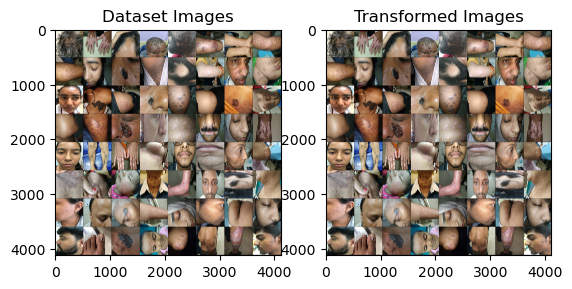

In [11]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        print(input_tensor.shape, transformed_input_tensor.shape, max(input_tensor.flatten()), max(transformed_input_tensor.flatten()))
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

train_loss, train_lcnn, train_acc = [],[],[]
test_loss, test_lcnn, test_acc = [],[],[]
for epoch in range(1, 80 + 1):
    train(epoch)
    a,b,c = train_conf()
    train_loss.append(a)
    train_lcnn.append(b)
    train_acc.append(c)
    a,b,c = test()
    test_loss.append(a)
    test_lcnn.append(b)
    test_acc.append(c)
    if epoch == 30 or epoch == 45 or epoch == 60:
        path = f'/home/siddhant/data/MedicalSTN/models/lavstnresnetfulllcnnRGB/{epoch}'
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(model.state_dict(), f'{path}/statedict.pt')
        torch.save(model, f'{path}/model.pt')
        torch.save(optimizer, f'{path}/optimizer.pt')
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, f'{path}/statedict_full.pt')
print(train_loss, train_lcnn, train_acc, test_loss, test_lcnn, test_acc)

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

In [12]:
print((test_acc)[47])

42.80078895463511


In [13]:
with torch.no_grad():
    model.eval()
    test_loss = 0
    lcnn_loss = 0
    correct = 0
    preds = []
    targets = []
    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        output, layer = model(data)

        # sum up batch loss
        test_loss += F.nll_loss(output, target, size_average=False).item()
        lcnn_loss += 0.05*torch.mean(torch.square(layer))
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds.extend(np.array(pred.cpu()))
        targets.extend(np.array(target.cpu()))
    from sklearn.metrics import confusion_matrix
    conf_mat=confusion_matrix(targets, preds)
    a = conf_mat
    #TODO make confusion matrix
    test_loss /= len(test_loader.dataset)
    lcnn_loss /= len(train_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, LCNN Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, lcnn_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))
for i in range(len(a[0])):
    print(a[i][i], np.sum(a[i]))
with torch.no_grad():
    model.eval()
    train_loss = 0
    lcnn_loss = 0
    correct = 0
    preds = []
    targets = []
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        output, layer = model(data)
        # sum up batch loss
        train_loss += F.nll_loss(output, target, size_average=False).item()
        lcnn_loss += 0.05*torch.mean(torch.square(layer))
        # get the index of the max log-probability
        pred = output.max(1, keepdim=True)[1]
        # print(pred)
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds.extend(np.array(pred.cpu()))
        targets.extend(np.array(target.cpu()))
    from sklearn.metrics import confusion_matrix
    conf_mat=confusion_matrix(targets, preds)
    a = conf_mat
    train_loss /= len(train_loader.dataset)
    lcnn_loss /= len(train_loader.dataset)
    print(train_loss)
    print(lcnn_loss)
    print('\nTrain set: Average loss: {:.4f}, LCNN Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(train_loss, lcnn_loss, correct, len(train_loader.dataset),
                  100. * correct / len(train_loader.dataset)))
for i in range(len(a[0])):
    print(a[i][i], np.sum(a[i]))

  0%|          | 0/8 [00:00<?, ?it/s]


Test set: Average loss: 2.9193, LCNN Loss: 0.0007, Accuracy: 220/507 (43%)

2 4
57 59
0 1
1 3
4 17
8 12
0 4
0 3
15 20
0 4
0 1
0 1
0 3
0 1
0 1
1 4
0 0
0 2
0 2
0 3
0 1
0 1
0 1
0 4
8 12
0 1
0 2
2 5
0 11
4 18
0 0
0 1
0 0
5 21
1 4
0 1
0 1
0 1
0 1
2 7
3 5
1 7
0 1
1 3
0 0
1 2
5 18
0 1
0 4
0 1
0 2
26 44
5 35
0 0
1 4
0 1
0 1
0 1
0 1
0 2
34 55
0 1
3 8
0 0
1 1
23 46
0 0
0 1
1 2
0 1
0 1
0 1
0 1
0 0
0 0
0 1
1 4
0 1
0 1
0 1
0 0
0 1
3 4
1 1
0 0
0 1
0 1
0 0
0 2


  0%|          | 0/33 [00:00<?, ?it/s]

0.011257630190980038
tensor(0.0043)

Train set: Average loss: 0.0113, LCNN Loss: 0.0043, Accuracy: 2073/2079 (100%)

15 16
238 238
4 4
11 11
67 67
47 47
1 1
14 14
10 10
81 81
16 16
1 1
6 6
4 4
11 11
2 2
1 1
1 1
2 2
2 2
1 1
1 1
1 1
1 1
3 3
17 17
1 1
1 1
2 2
1 1
6 6
6 6
11 11
1 1
4 4
2 2
3 3
1 1
18 18
49 49
1 1
5 5
8 8
21 21
44 44
70 70
2 2
1 1
2 2
1 1
1 1
1 1
1 1
81 82
18 18
4 4
3 3
6 6
1 1
1 1
2 2
1 1
26 26
21 21
30 30
1 1
1 1
1 1
2 2
11 12
1 1
1 1
2 2
7 7
2 2
72 72
4 4
1 1
17 17
5 5
2 2
2 2
2 2
10 10
1 1
175 175
1 1
141 142
1 1
14 14
1 1
2 2
3 3
2 2
2 2
1 1
7 7
221 221
4 4
30 30
1 1
1 1
1 1
5 5
182 183
2 2
5 5
6 6
2 2
1 1
1 1
2 2
2 2
6 6
1 1
2 2
2 2
1 1
1 1
2 2
4 4
1 1
1 1
14 14
1 1
3 3
2 2
3 3
3 3
2 2
6 6
15 15
2 2
1 1
1 1
3 4
1 1
2 2
1 1
1 1
1 1
2 2
1 1
2 2
2 2
6 6


In [14]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    # inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        print(input_tensor.shape, transformed_input_tensor.shape, max(input_tensor.flatten()), max(transformed_input_tensor.flatten()))
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

visualize_stn()

torch.Size([64, 3, 512, 512]) torch.Size([64, 3, 512, 512]) tensor(1.) tensor(1.)


In [15]:
path = '/home/siddhant/data/MedicalSTN/models/lavstnresnetfulllcnnRGB/'
if not os.path.exists(path):
    os.makedirs(path)
torch.save(model.state_dict(), f'{path}/statedict.pt')
torch.save(model, f'{path}/model.pt')
torch.save(optimizer, f'{path}/optimizer.pt')
state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
torch.save(state, f'{path}/statedict_full.pt')

In [5]:
from itertools import combinations
import numpy as np
ranNums=np.random.randint(low=0, high=20, size=10)
print(ranNums)
data_train = np.arange(75).reshape(25,3)
data_train_used=data_train[ranNums,:]
print(data_train_used)
LP = range(data_train_used.shape[0])

[17  0  8  9  3  3  3  5 16 15]
[[51 52 53]
 [ 0  1  2]
 [24 25 26]
 [27 28 29]
 [ 9 10 11]
 [ 9 10 11]
 [ 9 10 11]
 [15 16 17]
 [48 49 50]
 [45 46 47]]
